In [0]:
# importing necessary packeges
import urllib.request
import xml.etree.ElementTree as ET
import gensim
import os
import collections
import smart_open
import random
from sklearn.model_selection import train_test_split
from sklearn.svm import NuSVC
from sklearn.metrics import classification_report
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Utility methods

In [0]:
# A method to compute the similarity ratio between two strings
def similarityRatio (firstS, secondS):

  # Remove ',' from input
  firstS = firstS.replace(',', '')
  secondS = secondS.replace(',', '')
  
  # Convert string into list by splitting in spaces
  firstS = firstS.split()                                                       
  secondS = secondS.split()
  
  # Compute the fraction of common words between the two sentences
  commonWords = 0.0
  
  for i in range(len(firstS)):
    for j in range(len(secondS)):
      if firstS[i] == secondS[j]:
        commonWords = commonWords + 1
        
  return commonWords / (len(firstS) + len(secondS))

In [0]:
# A method to check if two strings have the same negation word
def negation (firstS, secondS):

  # Remove ',' from input
  firstS = firstS.replace(',', '')                                              
  secondS = secondS.replace(',', '')
  
  # Convert string into list by splitting in spaces
  firstS = firstS.split()                                                       
  secondS = secondS.split()
  
  negationWords = ['no', 'never', 'not', 'nothing', 'no one', 'without', 'nobody']
  firstFlag = 0
  secondFlag = 0
  
  for i in range(len(firstS)):
    for j in range(len(negationWords)):
      if firstS[i] == negationWords[j]:
        firstFlag = 1
      
  for i in range(len(secondS)):
    for j in range(len(negationWords)):
      if secondS[i] == negationWords[j]:
        secondFlag = 1     
  
  if (firstFlag == secondFlag):
    return 0
  else:
     return 1

#Reading RTE data and process it

In [0]:
"""
Each node in the file's tree stores three attributes which are
  the first part of a user story pair, the second part of a user story pair, and the label of the pair.

Each attribute is stored in a seperate list which are
  firstParts, secondParts, and labels respectively.

After reading the data, firstParts and secondParts lists will be concatenated
  and saved in the list inputData where each entry in inputData is a pair of user stories.
"""

inputFile = urllib.request.URLopener()
fileNames = ['RTE1_dev1_3ways.xml', 'RTE1_dev2_3ways.xml', 'RTE1_test_3ways.xml', 'RTE2_dev_3ways.xml', 'RTE2_test_3ways.xml', 'RTE3_dev_3ways.xml', 'RTE3_test_3ways.xml']

firstParts = []
secondParts = []
inputData = []
labels = []

for name in fileNames:
  file_name = 'https://nlp.stanford.edu/projects/contradiction/' + name
  inputFile.retrieve(file_name, "file.xml")
  tree = ET.parse('file.xml')

  for node in tree.iter('t'):
    firstParts.append(node.text)

  for node in tree.iter('h'):
    secondParts.append(node.text)

  for node in tree.iter('pair'):
    if node.attrib['entailment'] == 'UNKNOWN':
      labels.append('NO')
    else:
      labels.append(node.attrib['entailment'])

In [0]:
inputData = firstParts.copy()

for i in range(len(inputData)):
  inputData[i] = inputData[i] + ' ' + secondParts[i]

In [0]:
print("Length of inputData list is: " + str(len(inputData)))
print("Length of firstParts list is: " + str(len(firstParts)) + "\n")

print("First Entry in inputData list is:\n" + inputData[0] + "\n")
print("First Entry in firstParts list is:\n" + firstParts[0] + "\n")
print("First Entry in secondParts list is:\n" + secondParts[0] + "\n")

Length of inputData list is: 4567
Length of firstParts list is: 4567

First Entry in inputData list is:
Crude oil for April delivery traded at $37.80 a barrel, down 28 cents Crude oil prices rose to $37.80 per barrel

First Entry in firstParts list is:
Crude oil for April delivery traded at $37.80 a barrel, down 28 cents

First Entry in secondParts list is:
Crude oil prices rose to $37.80 per barrel



In [0]:
# Computing the ratio negation features
ratio = []
for i in range(len(firstParts)):
  ratio.append(similarityRatio(firstParts[i], secondParts[i]))

negationVector = []
for i in range(len(firstParts)):
  negationVector.append(negation(firstParts[i], secondParts[i]))

In [0]:
print(len(ratio))
print(len(negationVector))

4567
4567


In [0]:
# converting NO to 1s, and YES to 0s
# NO labels mean contradiction

print("Labels before encoding:")

for i in range(10):
  print (labels[i])
  
for i in range(len(labels)):
  if labels[i] == 'NO':
    labels[i] = 1
  else:
      labels[i] = 0


contradictions = 0
consistanncies = 0

print("\nLabels after encoding:")

for i in range(10):
  print (labels[i])

for i in range(len(labels)):
  if labels[i] == 1:
    contradictions = contradictions + 1
  else:
    consistanncies = consistanncies + 1
    
#print(c)
#print(r)
#print (len(labels))

Labels before encoding:
NO
NO
YES
NO
YES
YES
NO
NO
YES
YES

Labels after encoding:
1
1
0
1
0
0
1
1
0
0


In [0]:
# Tagging documents (e.g., inputData list) and placc them in tagged list
# Which will be used by DM model

tagged = []
for i in range (len(inputData)):
  tagged.append(gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(inputData[i]), [i]))
  
print("Length of tagged list is: " + str(len(tagged)))

Length of tagged list is: 4567


# Creating the 256 models

In [0]:
windwos = [4, 6, 8, 10]
vectorSizes = [5, 10, 15, 20]
NofEpochs = [50, 100, 150, 200]
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

parameterList = []
iteration = 0

for windowS in windwos:
  for vectorS in vectorSizes:
    for nEpochs in NofEpochs:
      for kernelF in kernels:
         
        iteration += 1
        
        doc2vecModel = gensim.models.doc2vec.Doc2Vec(epochs=nEpochs, window = windowS, vector_size=vectorS, alpha=0.1, min_alpha=0.0000001, min_count=0, dm = 1, sample = 10e-6, negative = 5, dm_concat = 0)
        doc2vecModel.build_vocab(tagged)
        doc2vecModel.train(tagged, total_examples=doc2vecModel.corpus_count, epochs=doc2vecModel.epochs)

        inputVectors = []
        for i in range(len(doc2vecModel.docvecs)):
          inputVectors.append(doc2vecModel.docvecs[i])


        inputData = []
        for i in range(len(inputVectors)):
          inputData.append(np.concatenate((inputVectors[i], ratio[i], negationVector[i]), axis=None))
        
        trainData, testData, trainLabels, testLabels = train_test_split(inputData, labels, test_size=0.1, random_state=42)

        clf = NuSVC(kernel  = kernelF , gamma = 'scale', probability=True)
        clf.fit(trainData, trainLabels)

        predictions = clf.predict(testData)

        t = 0
        for i in range(len(predictions)):
          if predictions[i] == testLabels[i]:
            t = t + 1

        parameterList.append([windowS, vectorS, nEpochs, kernelF, t / len(predictions)])
        
        if iteration > 250:
          with open('parametersTillIteration' + str(iteration) + '.txt', 'w') as filehandle:  
            for listitem in parameterList:
              filehandle.write('%s\n' % listitem)
        
        if iteration % 10 == 0:
        
          with open('parametersTillIteration' + str(iteration) + '.txt', 'w') as filehandle:  
            for listitem in parameterList:
              filehandle.write('%s\n' % listitem)
              
          print("Iteration " + str(iteration) + " out of 256 iterations")

Iteration 100 out of 256 iterations
Iteration 100 out of 256 iterations
Iteration 110 out of 256 iterations
Iteration 110 out of 256 iterations
Iteration 120 out of 256 iterations
Iteration 120 out of 256 iterations
Iteration 130 out of 256 iterations
Iteration 130 out of 256 iterations
Iteration 140 out of 256 iterations
Iteration 140 out of 256 iterations
Iteration 150 out of 256 iterations
Iteration 150 out of 256 iterations
Iteration 160 out of 256 iterations
Iteration 160 out of 256 iterations
Iteration 170 out of 256 iterations
Iteration 170 out of 256 iterations
Iteration 180 out of 256 iterations
Iteration 180 out of 256 iterations
Iteration 190 out of 256 iterations
Iteration 190 out of 256 iterations
Iteration 200 out of 256 iterations
Iteration 200 out of 256 iterations
Iteration 210 out of 256 iterations
Iteration 210 out of 256 iterations
Iteration 220 out of 256 iterations
Iteration 220 out of 256 iterations
Iteration 230 out of 256 iterations
Iteration 230 out of 256 ite

#Some Analysis

In [0]:
file = open("parametersTillIteration256.txt", "r")

lines = file.readlines()

parameters = []

for line in lines:
  #s = line.split([',', '[', ']'])
  parameters.append(line)
  
print(len(parameters))
print(parameters[0])

256
[4, 5, 50, 'linear', 0.5317286652078774]



In [0]:
print(parameters[0][-20:-2])

0.5317286652078774


In [0]:
accuracies = []

for i in range (len(parameters)):
  accuracies.append(parameters[i][-20:-2])
  
print(len(accuracies))

print(accuracies[0])
print(accuracies[1])
print(accuracies[2])

256
0.5317286652078774
.47702407002188185
0.4989059080962801


In [0]:
accuracies = np.asarray(accuracies).astype(np.float)

print(np.amax(accuracies))
print(np.argmax(accuracies))
print(accuracies[np.argmax(accuracies)])




0.5667396061269147
54
0.5667396061269147


In [0]:
print(np.amax(accuracies))
print(np.amin(accuracies))
print(np.mean(accuracies))
print(np.std(accuracies))

0.5667396061269147
0.4485776805251641
0.5125649617067833
0.022141420658429615


In [0]:
bestAccuracies = []
indecies = []

for i in range (5):
  bestAccuracies.append(np.amax(accuracies))
  
  offset = 0
  for j in range (len(indecies)):
    if np.argmax(accuracies) > indecies[j]:
      offset += 1
  
  
  indecies.append(np.argmax(accuracies) + offset)
  accuracies = np.delete(accuracies, np.argmax(accuracies))



print(len(bestAccuracies))
print(bestAccuracies)
print(indecies)

5
[0.5667396061269147, 0.5645514223194749, 0.5645514223194749, 0.5601750547045952, 0.5601750547045952]
[54, 18, 110, 106, 228]


In [0]:
with open('bestParameters.txt', 'w') as filehandle:  
  for i in range (len(indecies)):
    filehandle.write('%s\n' % parameters[indecies[i]])

In [0]:
for i in range (len(indecies)):
    print(parameters[indecies[i]])
    print(indecies[i])

[4, 20, 100, 'rbf', 0.5667396061269147]

54
[4, 10, 50, 'rbf', 0.5645514223194749]

18
[6, 15, 200, 'rbf', 0.5645514223194749]

110
[6, 15, 150, 'rbf', 0.5601750547045952]

106
[10, 15, 100, 'linear', 0.5601750547045952]

228


#Best parameters


In [0]:
parametersWithMeans = []

In [0]:
doc2vecModel = gensim.models.doc2vec.Doc2Vec(epochs=100, window = 4, vector_size=20, alpha=0.1, min_alpha=0.0000001, min_count=0, dm = 1, sample = 10e-6, negative = 5, dm_concat = 0)
doc2vecModel.build_vocab(taggedCombined)
doc2vecModel.train(taggedCombined, total_examples=doc2vecModel.corpus_count, epochs=doc2vecModel.epochs)

inputVectors = []
for i in range(len(doc2vecModel.docvecs)):
  inputVectors.append(doc2vecModel.docvecs[i])
  
inputData = []
for i in range(len(inputVectors)):
  inputData.append(np.concatenate((inputVectors[i], ratio[i], negationVector[i]), axis=None))

trainData, testData, trainLabels, testLabels = train_test_split(inputData, labels, test_size=0.1, random_state=42)

clf = NuSVC(kernel  = 'rbf' , gamma = 'scale', probability=True)
clf.fit(trainData, trainLabels)

accuracies = []

for i in range (30):
  predictions = clf.predict(testData)

  t = 0
  for i in range(len(predictions)):
    if predictions[i] == testLabels[i]:
      t = t + 1
  accuracies.append(t / len(predictions))

accuracies = np.asarray(accuracies).astype(np.float)

parametersWithMeans.append([4, 20, 100, 'rbf', np.mean(accuracies)])


In [0]:
doc2vecModel = gensim.models.doc2vec.Doc2Vec(epochs=50, window = 4, vector_size=10, alpha=0.1, min_alpha=0.0000001, min_count=0, dm = 1, sample = 10e-6, negative = 5, dm_concat = 0)
doc2vecModel.build_vocab(taggedCombined)
doc2vecModel.train(taggedCombined, total_examples=doc2vecModel.corpus_count, epochs=doc2vecModel.epochs)

inputVectors = []
for i in range(len(doc2vecModel.docvecs)):
  inputVectors.append(doc2vecModel.docvecs[i])
  
inputData = []
for i in range(len(inputVectors)):
  inputData.append(np.concatenate((inputVectors[i], ratio[i], negationVector[i]), axis=None))

trainData, testData, trainLabels, testLabels = train_test_split(inputData, labels, test_size=0.1, random_state=42)

clf = NuSVC(kernel  = 'rbf' , gamma = 'scale', probability=True)
clf.fit(trainData, trainLabels)

accuracies = []

for i in range (30):
  predictions = clf.predict(testData)

  t = 0
  for i in range(len(predictions)):
    if predictions[i] == testLabels[i]:
      t = t + 1
  accuracies.append(t / len(predictions))

accuracies = np.asarray(accuracies).astype(np.float)

parametersWithMeans.append([4, 10, 50, 'rbf', np.mean(accuracies)])

In [0]:
doc2vecModel = gensim.models.doc2vec.Doc2Vec(epochs=200, window = 6, vector_size=15, alpha=0.1, min_alpha=0.0000001, min_count=0, dm = 1, sample = 10e-6, negative = 5, dm_concat = 0)
doc2vecModel.build_vocab(taggedCombined)
doc2vecModel.train(taggedCombined, total_examples=doc2vecModel.corpus_count, epochs=doc2vecModel.epochs)

inputVectors = []
for i in range(len(doc2vecModel.docvecs)):
  inputVectors.append(doc2vecModel.docvecs[i])

inputData = []
for i in range(len(inputVectors)):
  inputData.append(np.concatenate((inputVectors[i], ratio[i], negationVector[i]), axis=None))

trainData, testData, trainLabels, testLabels = train_test_split(inputData, labels, test_size=0.1, random_state=42)

clf = NuSVC(kernel  = 'rbf' , gamma = 'scale', probability=True)
clf.fit(trainData, trainLabels)

accuracies = []

for i in range (30):
  predictions = clf.predict(testData)

  t = 0
  for i in range(len(predictions)):
    if predictions[i] == testLabels[i]:
      t = t + 1
  accuracies.append(t / len(predictions))

accuracies = np.asarray(accuracies).astype(np.float)

parametersWithMeans.append([6, 15, 200, 'rbf', np.mean(accuracies)])

In [0]:
doc2vecModel = gensim.models.doc2vec.Doc2Vec(epochs=150, window = 6, vector_size=15, alpha=0.1, min_alpha=0.0000001, min_count=0, dm = 1, sample = 10e-6, negative = 5, dm_concat = 0)
doc2vecModel.build_vocab(taggedCombined)
doc2vecModel.train(taggedCombined, total_examples=doc2vecModel.corpus_count, epochs=doc2vecModel.epochs)

inputVectors = []
for i in range(len(doc2vecModel.docvecs)):
  inputVectors.append(doc2vecModel.docvecs[i])

inputData = []
for i in range(len(inputVectors)):
  inputData.append(np.concatenate((inputVectors[i], ratio[i], negationVector[i]), axis=None))

trainData, testData, trainLabels, testLabels = train_test_split(inputData, labels, test_size=0.1, random_state=42)

clf = NuSVC(kernel  = 'rbf' , gamma = 'scale', probability=True)
clf.fit(trainData, trainLabels)

accuracies = []

for i in range (30):
  predictions = clf.predict(testData)

  t = 0
  for i in range(len(predictions)):
    if predictions[i] == testLabels[i]:
      t = t + 1
  accuracies.append(t / len(predictions))

accuracies = np.asarray(accuracies).astype(np.float)

parametersWithMeans.append([6, 15, 150, 'rbf', np.mean(accuracies)])

In [0]:
doc2vecModel = gensim.models.doc2vec.Doc2Vec(epochs=100, window = 10, vector_size=15, alpha=0.1, min_alpha=0.0000001, min_count=0, dm = 1, sample = 10e-6, negative = 5, dm_concat = 0)
doc2vecModel.build_vocab(taggedCombined)
doc2vecModel.train(taggedCombined, total_examples=doc2vecModel.corpus_count, epochs=doc2vecModel.epochs)

inputVectors = []
for i in range(len(doc2vecModel.docvecs)):
  inputVectors.append(doc2vecModel.docvecs[i])

inputData = []
for i in range(len(inputVectors)):
  inputData.append(np.concatenate((inputVectors[i], ratio[i], negationVector[i]), axis=None))

trainData, testData, trainLabels, testLabels = train_test_split(inputData, labels, test_size=0.1, random_state=42)

clf = NuSVC(kernel  = 'linear' , gamma = 'scale', probability=True)
clf.fit(trainData, trainLabels)

accuracies = []

for i in range (30):
  predictions = clf.predict(testData)

  t = 0
  for i in range(len(predictions)):
    if predictions[i] == testLabels[i]:
      t = t + 1
  accuracies.append(t / len(predictions))

accuracies = np.asarray(accuracies).astype(np.float)

parametersWithMeans.append([10, 15, 100, 'linear', np.mean(accuracies)])

In [0]:
with open('parametersWithMeans.txt', 'w') as filehandle:  
  for i in range (len(parametersWithMeans)):
    filehandle.write('%s\n' % parametersWithMeans[i])

#Final model

In [0]:
precisions = []
recalls = []
accuracies = []

doc2vecModel = gensim.models.doc2vec.Doc2Vec(epochs=150, window = 6, vector_size=15, alpha=0.1, min_alpha=0.0000001, min_count=0, dm = 1, sample = 10e-6, negative = 5, dm_concat = 0)
doc2vecModel.build_vocab(tagged)
doc2vecModel.train(tagged, total_examples=doc2vecModel.corpus_count, epochs=doc2vecModel.epochs)

inputVectors = []
for i in range(len(doc2vecModel.docvecs)):
  inputVectors.append(doc2vecModel.docvecs[i])

inputData = []
for i in range(len(inputVectors)):
  inputData.append(np.concatenate((inputVectors[i], ratio[i], negationVector[i]), axis=None))

trainData, testData, trainLabels, testLabels = train_test_split(inputData, labels, test_size=0.1, random_state=42)


clf = NuSVC(kernel  = 'rbf' , gamma = 'scale', probability=True)
clf.fit(trainData, trainLabels)

for i in range (30):
  
  tp = 0
  tn = 0
  fp = 0
  fn = 0
  
  predictions = clf.predict(testData)

  
  for i in range(len(predictions)):
    if predictions[i] == testLabels[i] and testLabels[i] == 1:
      tp = tp + 1
      
    if predictions[i] == testLabels[i] and testLabels[i] == 0:
      tn = tn + 1
    
    if predictions[i] != testLabels[i] and testLabels[i] == 0:
      fp = fp + 1
      
    if predictions[i] != testLabels[i] and testLabels[i] == 1:
      fn = fn + 1

  precisions.append(tp / (tp + fp))
  recalls.append(tp / (tp + fn))
  accuracies.append((tp + tn)/ (tp + tn + fn + fp))
  
print((tp + tn + fn + fp))  
print(len(predictions))

precisions = np.asarray(precisions).astype(np.float)
recalls = np.asarray(recalls).astype(np.float)
accuracies = np.asarray(accuracies).astype(np.float)
    
print("Average accutacy is :" + str(np.mean(accuracies)))
print("Average precision is :" + str(np.mean(precisions)))
print("Average recall is :" + str(np.mean(recalls)))


457
457
Average accutacy is :0.5032822757111596
Average precision is :0.5251141552511417
Average recall is :0.4831932773109244


In [0]:
# Reducing vectors into 3-dimensional space

inputVectors_embedded = TSNE(n_components=3).fit_transform(inputVectors)
print(len(inputVectors_embedded[0]))

3


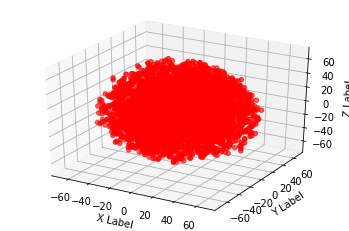

In [0]:
# Visualizing the reduced Vectors

x = []
y = []
z = []

for i in range(len(inputVectors_embedded)):
  x.append(inputVectors_embedded[i][0])
  y.append(inputVectors_embedded[i][1])
  z.append(inputVectors_embedded[i][2])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [0]:
# Reducing testData vectors into 3-dimensional space

testData_embedded = TSNE(n_components=3).fit_transform(testData)
print(len(testData_embedded[0]))

3


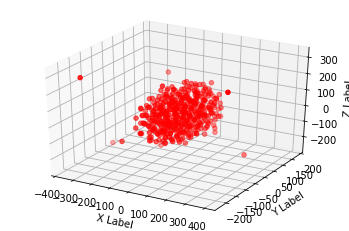

In [0]:
# Visualizing the reduced Vectors

x = []
y = []
z = []

for i in range(len(testData_embedded)):
  x.append(testData_embedded[i][0])
  y.append(testData_embedded[i][1])
  z.append(testData_embedded[i][2])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

## Reading user stories

In [0]:
# Reading the file containing conflicting USs and
# store them in conflictingUSs list

file = open("conflictingUSs.txt", "r")

lines = file.readlines()

conflictingUSs = []

for line in lines:
  s = line.split(',')
  conflictingUSs.append(s[1])
  
print("Length of conflictingUSs list is: " + str(len(conflictingUSs)))
print("The first sentence in the list is: " + conflictingUSs[0])

Length of conflictingUSs list is: 50
The first sentence in the list is:  I want to access the descriptive information about the images scanned for my institutions needs.



In [0]:
# Reading the file containing consistant USs and
# store them in consistantUSs list

file = open("consistantUSs.txt", "r")

lines = file.readlines()

consistantUSs = []

for line in lines:
  s = line.split(',')
  consistantUSs.append(s[1])
  
print("Length of consistantUSs list is: " + str(len(consistantUSs)))
print("The first sentence in the list is: " + consistantUSs[0])

Length of consistantUSs list is: 50
The first sentence in the list is:  I want to add the updates on a FABS submission to be modified when the publishStatus changes


In [0]:
# creating a dummy list to store both
# conflictingUSs and consistantUSs lists

inputDataUSsDummy = conflictingUSs + consistantUSs

print(len(inputDataUSsDummy))
print(inputDataUSsDummy[0])
print(inputDataUSsDummy[1])
print(inputDataUSsDummy[50])
print(inputDataUSsDummy[51])

100
 I want to access the descriptive information about the images scanned for my institutions needs.

 descriptive information should not be accessed by all types of users.

 I want to add the updates on a FABS submission to be modified when the publishStatus changes
 I want New Relic to provide useful data across all applications.



In [0]:
# Store USs in inputDataUSs such that each entry is 
# a pair of USs

inputDataUSs = []

for i in range (0, 100, 2):
  inputDataUSs.append(inputDataUSsDummy[i].replace('.\n', '') + inputDataUSsDummy[i+1].replace('.\n', ''))


print("Length of inputDataUSs list is: " + str(len(inputDataUSs)))
print("The first entry (first conflicting pair) is:\n" + inputDataUSs[0])
print("\nThe second entry (second conflicting pair) is:\n" + inputDataUSs[1])
print("\nThe 26th entry (first consistant pair) is:\n" + inputDataUSs[25])
print("\nThe 27th entry (second consistant pair) is:\n" + inputDataUSs[26])

Length of inputDataUSs list is: 50
The first entry (first conflicting pair) is:
 I want to access the descriptive information about the images scanned for my institutions needs descriptive information should not be accessed by all types of users

The second entry (second conflicting pair) is:
 I want to create a protocol and assign metadata to any stag users are not allowed to create protocols

The 26th entry (first consistant pair) is:
 I want to add the updates on a FABS submission to be modified when the publishStatus changes I want New Relic to provide useful data across all applications

The 27th entry (second consistant pair) is:
 I want to be confident that the data coming from SAM is complete I want my domain models to be indexed properly


In [0]:
# Computing the ratio feature

ratioUSs = []

for i in range(0, len(conflictingUSs), 2):
  ratioUSs.append(similarityRatio(conflictingUSs[i], conflictingUSs[i+1]))
  
for i in range(0, len(consistantUSs), 2):
  ratioUSs.append(similarityRatio(consistantUSs[i], consistantUSs[i+1]))
  
print(len(ratioUSs))

50


In [0]:
# Computing the negation feature

negationVectorUSs = []


for i in range(0, len(conflictingUSs), 2):
  negationVectorUSs.append(negation(conflictingUSs[i], conflictingUSs[i+1]))
  
for i in range(0, len(consistantUSs), 2):
  negationVectorUSs.append(negation(consistantUSs[i], consistantUSs[i+1]))
  
print(negationVectorUSs)
print(len(negationVectorUSs))

[1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
50


In [0]:
# Create labels for US data such that
# 1 means contradiction

labelsUSs = []

for i in range(25):
  labelsUSs.append(1)
  
for i in range(25):
  labelsUSs.append(0)
  
print(len(labelsUSs))
print(labelsUSs)

50
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [0]:
#Encode USs as vectors by passing them to the DM model

USsVectors = []

for i in range (len(inputDataUSs)):
  USsVectors.append(doc2vecModel.infer_vector(inputDataUSs[i]))

print(len(USsVectors))
print(USsVectors[0])
print(USsVectors[1])
#print(inputVectors)

50
[-0.0029299  -0.0328425   0.03188535  0.01910786  0.01660023  0.01855111
 -0.00754348 -0.01308437 -0.02813253 -0.03057876  0.00127178  0.00936915
  0.02399012 -0.01386363 -0.01505082]
[-0.0328446   0.00222116 -0.01284052 -0.00422876 -0.00029456  0.02180549
  0.00019457  0.02469382 -0.00063149  0.01022958 -0.02135656  0.02777162
 -0.01331105 -0.00703232 -0.00840981]


In [0]:
# Reducing vectors into 3-dimensional space

USsVectors_embedded = TSNE(n_components=3).fit_transform(USsVectors)
print(len(USsVectors_embedded[0]))

3


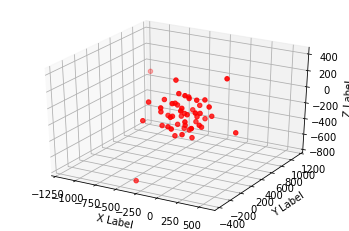

In [0]:
# Visualizing the reduced vectors

x = []
y = []
z = []

for i in range(len(USsVectors_embedded)):
  x.append(USsVectors_embedded[i][0])
  y.append(USsVectors_embedded[i][1])
  z.append(USsVectors_embedded[i][2])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [0]:
# Combine vectors with the two features
# and store them in concatenatedFeatures list

concatenatedFeatures = []

for i in range(len(USsVectors)):
  concatenatedFeatures.append(np.concatenate((USsVectors[i], ratioUSs[i], negationVectorUSs[i]), axis=None))
  
print(concatenatedFeatures[0])
print(len(concatenatedFeatures[0]))
print(len(concatenatedFeatures))

[-0.0029299  -0.0328425   0.03188535  0.01910786  0.01660023  0.01855111
 -0.00754348 -0.01308437 -0.02813253 -0.03057876  0.00127178  0.00936915
  0.02399012 -0.01386363 -0.01505082  0.07692308  1.        ]
17
50


In [0]:
#Shuffle (mixing) the data

import random
combined = list(zip(concatenatedFeatures, labelsUSs))

random.shuffle(combined)

concatenatedFeatures[:], labelsUSs[:] = zip(*combined)

In [0]:
#Passing the data to SVM
precisions = []
recalls = []
accuracies = []

for i in range (30):
  
  tp = 0
  tn = 0
  fp = 0
  fn = 0
  
  predictions = clf.predict(inputData)

  
  for i in range(len(predictions)):
    if predictions[i] == labels[i] and labels[i] == 1:
      tp = tp + 1
      
    if predictions[i] == labels[i] and labels[i] == 0:
      tn = tn + 1
    
    if predictions[i] != labels[i] and labels[i] == 0:
      fp = fp + 1
      
    if predictions[i] != labels[i] and labels[i] == 1:
      fn = fn + 1

  precisions.append(tp / (tp + fp))
  recalls.append(tp / (tp + fn))
  accuracies.append((tp + tn)/ (tp + tn + fn + fp))
  
print((tp + tn + fn + fp))  
print(len(predictions))

precisions = np.asarray(precisions).astype(np.float)
recalls = np.asarray(recalls).astype(np.float)
accuracies = np.asarray(accuracies).astype(np.float)
    
print("Average accutacy is :" + str(np.mean(accuracies)))
print("Average precision is :" + str(np.mean(precisions)))
print("Average recall is :" + str(np.mean(recalls)))

4567
4567
Average accutacy is :0.8708123494635426
Average precision is :0.8779936737460463
Average recall is :0.8585947856827222
